# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np

from os.path import join
import json
import datetime

import shap
from shap_selection import feature_selection

from sklearn.preprocessing import OneHotEncoder
import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams
from src.plots.functions import plot_3d_surface
from src.optimization.functions import opt_value

# if we want to create an iteractive plot or not
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

## General parameters

## Arrhythmia

**Dataset source**: http://odds.cs.stonybrook.edu/arrhythmia-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources**:

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. “Isolation forest.” 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

K. M. Ting, J. T. S. Chuan, and F. T. Liu. “Mass: A New Ranking Measure for Anomaly Detection.“, IEEE Transactions on Knowledge and Data Engineering, 2009.

F. Keller, E. Muller, K. Bohm.“HiCS: High-contrast subspaces for density-based outlier ranking.” ICDE, 2012.

In [5]:
dataset_id = 'arrhythmia'

data = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)
data.shape

(452, 275)

In [6]:
pd.pivot_table(data,
             values = 'Col1',
               index = 'y', 
              aggfunc = 'count')

,Col1
y,
0,386
1,66


In [7]:
excluded_cols = ['Col15', 'Col63', 'Col65', 'Col79', 'Col127', 'Col128','Col135', 'Col137', 'Col139','Col141','Col147', 'Col152', 'Col153', 'Col160', 'Col200', 'Col260', 'Col270']

### iForest

## Parameters

In [64]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

fi_shap_all = pd.read_parquet(path_fi_shap)
df = pd.read_parquet(path_shap)

df['shap_q1'] = df['shap_stab'].apply(lambda x: np.percentile(x, 75))
df['shap_q2'] = df['shap_stab'].apply(lambda x: np.percentile(x, 50))
df['shap_q3'] = df['shap_stab'].apply(lambda x: np.percentile(x, 25))

df['shap_ad_q2'] = df['shap_stab_ad'].apply(lambda x: np.percentile(x, 50))

df['shap_mean'] = df['shap_stab'].apply(lambda x: np.mean(x))


df['shap_stab'] = df['shap_q2']
df['shap_inestab'] = 1- df['shap_stab']


var = ['n_estimators', 'max_feats', 'n_feats', 'f1_median', 'precision', 'model_stab', 'shap_stab', 'shap_inestab', 'shap_q2', 'shap_mean']
df = df[var]

In [65]:
#df = df[df.n_estimators<=500]

## Optimization

In [66]:
df.sort_values('precision', ascending=False).head(5)

,n_estimators,max_feats,n_feats,f1_median,precision,model_stab,shap_stab,shap_inestab,shap_q2,shap_mean
1249,23,119,119,0.653846,0.653846,0.905724,0.751933,0.248067,0.751933,0.756614
1362,25,91,152,0.612245,0.652174,0.905024,0.724851,0.275149,0.724851,0.729193
1139,21,119,119,0.627451,0.640000,0.902499,0.746476,0.253524,0.746476,0.752197
1084,20,119,119,0.627451,0.640000,0.900374,0.749568,0.250432,0.749568,0.754184
1473,75,121,152,0.583333,0.636364,0.958187,0.815630,0.184370,0.815630,0.816375


In [67]:
df.shape

(2640, 10)

In [71]:
sorted_df = opt_value(df, lambda_=0.7, var2='shap_mean')

opt_x = int(sorted_df.iloc[0:1,:].n_estimators)
opt_y = int(sorted_df.iloc[0:1,:].n_feats)

sorted_df

,n_estimators,max_feats,n_feats,f1_median,precision,model_stab,shap_stab,shap_inestab,shap_q2,shap_mean,opt_value
1473,75,121,152,0.583333,0.636364,0.958187,0.815630,0.184370,0.815630,0.816375,0.690367
1629,150,94,94,0.541667,0.590909,0.977369,0.915453,0.084547,0.915453,0.907690,0.685943
2472,525,154,257,0.541667,0.590909,0.988149,0.903615,0.096385,0.903615,0.905323,0.685233
1249,23,119,119,0.653846,0.653846,0.905724,0.751933,0.248067,0.751933,0.756614,0.684676
1464,75,94,94,0.571429,0.608696,0.967779,0.865336,0.134664,0.865336,0.861457,0.684524
...,...,...,...,...,...,...,...,...,...,...,...
126,3,16,42,0.125000,0.136364,0.675673,0.672672,0.327328,0.672672,0.676922,0.298531
69,2,29,29,0.127660,0.142857,0.725362,0.640334,0.359666,0.640334,0.651048,0.295314
45,1,47,235,0.000000,0.000000,0.568073,0.956525,0.043475,0.956525,0.955913,0.286774
20,1,11,57,0.000000,0.000000,0.632707,0.873774,0.126226,0.873774,0.876190,0.262857


## Visualization of the results

In [81]:
# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'n_feats'])['max_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_n_trees = df.loc[idx].reset_index(drop=True)

# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'max_feats'])['n_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_max_feat = df.loc[idx].reset_index(drop=True)

In [82]:
df = df_n_trees.copy()

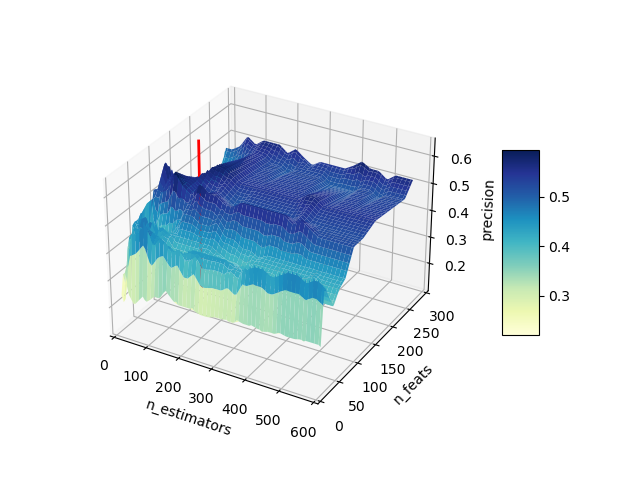

In [83]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'precision', cmap='YlGnBu', x_step=100, y_step=50, opt_x=opt_x, opt_y=opt_y, opt_color='red')


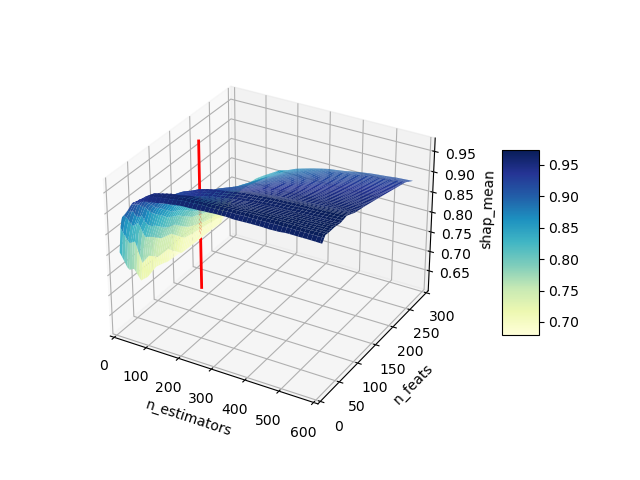

In [84]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'shap_mean', cmap='YlGnBu', x_step=100, y_step=50, opt_x=opt_x, opt_y=opt_y, opt_color='red')

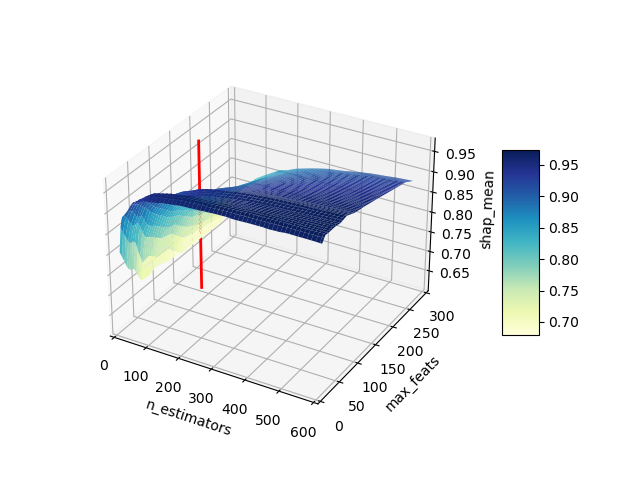

In [85]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'max_feats', 'shap_mean', cmap='YlGnBu', x_step=100, y_step=50, opt_x=opt_x, opt_y=opt_y, opt_color='red')


In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_3d_surface_multi_z(df, x_label, y_label, z_labels, cmap='inferno', y_step=10):
    """
    Generates a 3D surface plot for the specified columns in a pandas DataFrame.

    Parameters:
    - df: pandas.DataFrame containing the data.
    - x_label: The name of the column to be used as the X-axis.
    - y_label: The name of the column to be used as the Y-axis.
    - z_labels: A list of names for the columns to be used as multiple Z-axes.
    - cmap: The colormap for the surfaces. Defaults to 'inferno'.
    - y_step: The increment for ticks on the Y-axis. Defaults to 10.
    """
    # Creating figure
    fig = plt.figure()
    # Adding a subplot
    ax = fig.add_subplot(111, projection='3d')

    x = df[x_label].values
    y = df[y_label].values

    # Creating grid data, starting from 0 for both x and y
    xi = np.linspace(0, x.max(), 100)
    yi = np.linspace(0, y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    for z_label in z_labels:
        z = df[z_label].values
        # Interpolating z values on the grid
        zi = griddata((x, y), z, (xi, yi), method='linear')

        # Plotting surface plot
        ax.plot_surface(xi, yi, zi, cmap=cmap, edgecolor='none', label=z_label, alpha=0.7)

    # Adding labels
    ax.set_xlabel('Nº Trees')
    ax.set_ylabel('Nº of Selected Feat.')
    ax.set_zlabel('Value')

    # Ensure the axes start from 0 and dynamically adjust the end and ticks
    ax.set_xlim([0, x.max()])
    ax.set_ylim([0, y.max()])
    ax.set_xticks(np.arange(0, x.max(), max(x.max() / 6, 1)))
    ax.set_yticks(np.arange(0, y.max() + y_step, y_step))

    # Displaying the plot
    plt.show()

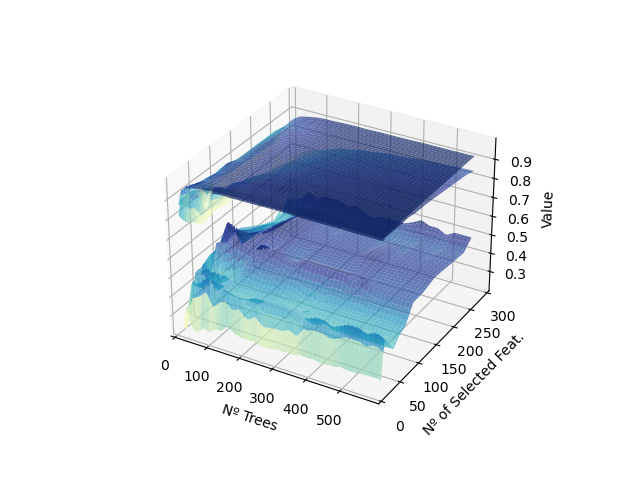

In [87]:
# Example usage (assuming 'df' is your DataFrame)Ç
plot_3d_surface_multi_z(df, 'n_estimators', 'n_feats', ['precision', 'shap_q2', 'model_stab'], cmap='YlGnBu', y_step=50)

In [20]:
var = ["n_estimators", "max_feats", "n_feats", "precision", "shap_q2"]

In [21]:
df[var].sort_values("precision")

,n_estimators,max_feats,n_feats,precision,shap_q2
2,1,29,29,0.105263,0.599222
33,4,8,8,0.125000,0.802237
275,50,8,8,0.136364,0.958226
13,2,29,29,0.142857,0.640334
4,1,57,57,0.157895,0.697977
...,...,...,...,...,...
238,22,119,119,0.625000,0.745574
106,10,119,119,0.625000,0.700796
216,20,119,119,0.640000,0.749568
227,21,119,119,0.640000,0.746476
